In [ ]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time 
import tqdm
import random
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import cv2

try:
    import albumentations
    from albumentations import torch as AT
except:
    ! pip install albumentations
    import albumentations
    from albumentations import torch as AT
#import pretrainedmodels

import scipy
import scipy.special

try:
    from pytorchcv.model_provider import get_model as ptcv_get_model
except:
    ! pip install pytorchcv
    from pytorchcv.model_provider import get_model as ptcv_get_model
    
cudnn.benchmark = True


In [ ]:
#####################
SEED = 152
#####################
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

seed_everything(SEED)
#base_dir = '../input/histopathologic-cancer-detection/'
MODEL_NAME = "densenet121"
#TEST_FRAC = 0.10
#SELECT_FOLD = 6
Final_Linear_Layer = 15


TRAIN_OR_PREDICT = "train"
#TRAIN_OR_PREDICT = "predict"
NUM_TTA = 4

if TRAIN_OR_PREDICT == "predict":
    SAVED_WEIGHT = '../input/dense1/dense1_model_val9861.pt'

#### InceptionV4 299 ####


In [ ]:
if MODEL_NAME == "cbam_resnet50":
    New_size = 224
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.125/cbam_resnet50-0605-a1172fe6.pth.zip
    ! unzip cbam_resnet50-0605-a1172fe6.pth.zip

    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("cbam_resnet50-0605-a1172fe6.pth"))
    #model_conv = ptcv_get_model("bam_resnet50", pretrained=True)

    #model_conv = pretrainedmodels.se_resnext101_32x4d()
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.output = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    
elif MODEL_NAME == "densenet121":
    New_size = 224
    #! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.3/densenet121-0803-f994107a.pth.zip
    #! unzip densenet121-0803-f994107a.pth.zip
    
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=True)
    #model_conv.load_state_dict(torch.load("densenet121-0803-f994107a.pth"))
    
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    #model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
    #                                  nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    model_conv.output = nn.Linear(in_features=1024, out_features=Final_Linear_Layer, bias=True)
    

elif MODEL_NAME == "nasnet_6a4032":
    New_size = 331
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.101/nasnet_6a4032-0421-f354d28f.pth.zip
    ! unzip nasnet_6a4032-0421-f354d28f.pth.zip
    
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("nasnet_6a4032-0421-f354d28f.pth"))
    
    model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))

elif MODEL_NAME == "InceptionV4":
    New_size = 299
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.105/inceptionv4-0529-5cb7b4e4.pth.zip
    ! unzip inceptionv4-0529-5cb7b4e4.pth.zip
    
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("inceptionv4-0529-5cb7b4e4.pth"))
    
    model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))

elif MODEL_NAME == "resnet34":
    New_size = 224
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.1/resnet34-0818-6f947d40.pth.zip
    ! unzip resnet34-0818-6f947d40.pth.zip
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("resnet34-0818-6f947d40.pth"))
    
    model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    
elif MODEL_NAME == "resnet50":
    New_size = 224
    #! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.147/resnet50-0658-828686d7.pth.zip
    #! unzip resnet50-0658-828686d7.pth.zip
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=True)
    #model_conv.load_state_dict(torch.load("resnet50-0658-828686d7.pth"))
    
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    #model_conv.last_linear = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
    #                                  nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    model_conv.output = nn.Linear(in_features=2048, out_features=Final_Linear_Layer, bias=True)
    
elif MODEL_NAME == "seresnet50":
    New_size = 224
    ! wget https://github.com/osmr/imgclsmob/releases/download/v0.0.11/seresnet50-0640-8820f2af.pth.zip
    ! unzip seresnet50-0640-8820f2af.pth.zip
    model_conv = ptcv_get_model(MODEL_NAME, pretrained=False)
    model_conv.load_state_dict(torch.load("seresnet50-0640-8820f2af.pth"))
    
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    model_conv.output = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
                                      nn.Dropout(0.8), nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    
elif MODEL_NAME == "bagnet33":
    New_size = 224
    try:
        import bagnets.pytorch
    except:
        ! pip install git+https://github.com/wielandbrendel/bag-of-local-features-models.git
        import bagnets.pytorch
    #! wget https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar
    model_conv = bagnets.pytorch.bagnet33(pretrained=True)
    #model_conv.load_state_dict(torch.load("bagnet32-2ddd53ed.pth.tar"))
    
    #model_conv.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    #model_conv.fc = nn.Sequential(nn.Dropout(0.6), nn.Linear(in_features=2048, out_features=512, bias=True), nn.SELU(),
    #                                  nn.Dropout(0.8),  nn.Linear(in_features=512, out_features=Final_Linear_Layer, bias=True))
    model_conv.fc = nn.Linear(in_features=2048, out_features=Final_Linear_Layer, bias=True)
    
elif MODEL_NAME == "bagnet17":
    New_size = 224
    try:
        import bagnets.pytorch
    except:
        ! pip install git+https://github.com/wielandbrendel/bag-of-local-features-models.git
        import bagnets.pytorch
    #! wget https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar
    model_conv = bagnets.pytorch.bagnet17(pretrained=True)
    #model_conv.load_state_dict(torch.load("bagnet16-105524de.pth.tar"))
    
    model_conv.fc = nn.Linear(in_features=2048, out_features=Final_Linear_Layer, bias=True)
    
elif MODEL_NAME == "bagnet9":
    New_size = 224
    try:
        import bagnets.pytorch
    except:
        ! pip install git+https://github.com/wielandbrendel/bag-of-local-features-models.git
        import bagnets.pytorch
    #! wget https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar
    model_conv = bagnets.pytorch.bagnet9(pretrained=True)
    #model_conv.load_state_dict(torch.load("bagnet16-105524de.pth.tar"))
    
    model_conv.fc = nn.Linear(in_features=2048, out_features=Final_Linear_Layer, bias=True)
    
else:
    print("wrong model name")
    exit(1)

In [ ]:
data_transforms_train = albumentations.Compose([
    albumentations.Resize(New_size, New_size),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    AT.ToTensor()
    ])

data_transforms_train2 = transforms.Compose([
    transforms.Resize((New_size, New_size)),
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])


In [ ]:
!rm -rf DLdata/
!rm -rf ./training/
!rm -rf ./validation/
!rm -rf ./test1/
!rm -rf ./__MACOSX/validation/._.DS_Store
!rm -rf ./__MACOSX/test1/._.DS_Store
!git clone https://github.com/SifanSong/DLdata.git
!unzip ./DLdata/training.zip
!unzip ./DLdata/validation.zip
!unzip ./DLdata/test1.zip

In [12]:
## import CV3 datasets
training_data = torchvision.datasets.ImageFolder('./training/', transform=data_transforms_train2)
val_data = torchvision.datasets.ImageFolder('./validation/', transform=data_transforms_train2)
test_data = torchvision.datasets.ImageFolder('./test1/', transform=data_transforms_train2)
## return are tuples (sample, target)
## https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
## https://github.com/williamFalcon/pytorch-imagenet-dataset
print(training_data)
print(val_data)
print(test_data)

print(training_data[0][0].shape)

Dataset ImageFolder
    Number of datapoints: 1200
    Root Location: ./training/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 300
    Root Location: ./validation/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 1200
    Root Location: ./test1/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEA

In [ ]:
train_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

In [ ]:
model_conv.cuda()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=4e-5)

scheduler = StepLR(optimizer, 5, gamma=0.2)
scheduler.step()



In [ ]:
#list(model_conv.children())

In [15]:
try:
    from torchsummary import summary
except:
    !pip install torchsummary
    from torchsummary import summary

summary(model_conv, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
   PreResInitBlock-5           [-1, 64, 56, 56]               0
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           8,192
      PreConvBlock-9          [-1, 128, 56, 56]               0
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
           Conv2d-12           [-1, 32, 56, 56]          36,864
     PreConvBlock-13           [-1, 32, 56, 56]               0
        DenseUnit-14           [-1, 96,

In [ ]:
#try:
#    from google.colab import files
#    uploaded = files.upload()
#except:
#    print("Not running on colab. Ignoring.")

In [ ]:
#!ls
#model_conv.load_state_dict(torch.load('model_val9466.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
try: 
    import torchbearer
except:
    !pip install torchbearer
    import torchbearer
from torchbearer import Trial
from torch import optim

start_epoch = 0
TOTAL_EPOCH = 40
INITIAL_LR = 4e-5

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_acc = []
test_loss = []

device = "cuda:0" if torch.cuda.is_available() else "cpu"

optimizer = optim.Adam(model_conv.parameters(), lr=INITIAL_LR)

tolerate = 0
best_val_acc = 0
patiance = 0

for i in range(start_epoch, TOTAL_EPOCH):
  print("Training starts: Epoch ", i)
  
  trial = Trial(model_conv, optimizer, criterion, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
  trial.run(epochs=1)
  
  results_training = trial.evaluate(data_key=torchbearer.TRAIN_DATA)
  train_loss.append(results_training['train_loss'])
  train_acc.append(results_training['train_acc'])
  
  results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
  val_loss.append(results['val_loss'])
  val_acc.append(results['val_acc'])
  
  results_test = trial.evaluate(data_key=torchbearer.TEST_DATA)
  test_loss.append(results_test['test_loss'])
  test_acc.append(results_test['test_acc'])
  
  if results['val_acc'] >= best_val_acc:
    best_val_acc = results['val_acc']
    torch.save(model_conv.state_dict(), 'model_val%d.pt'%(best_val_acc*10000))
    print(" --------- New best validation acc --------- ", best_val_acc)
    
    patiance = 0
    
  else:
    tolerate += 1
    patiance += 1
    print("tolerate: ", tolerate, ", patiance: ", patiance)
  
  if tolerate >= 3:
    INITIAL_LR /= 2
    optimizer = optim.Adam(model_conv.parameters(), lr=INITIAL_LR)
    tolerate = 0
    print("New LR: ", INITIAL_LR)
    
  if patiance > 15:
    break
    print("Early stopping")
    
    
  

Training starts: Epoch  0



 --------- New best validation acc ---------  0.753333330154419
Training starts: Epoch  1



 --------- New best validation acc ---------  0.8700000047683716
Training starts: Epoch  2



 --------- New best validation acc ---------  0.8766666650772095
Training starts: Epoch  3



 --------- New best validation acc ---------  0.9066666960716248
Training starts: Epoch  4



 --------- New best validation acc ---------  0.9166666865348816
Training starts: Epoch  5



 --------- New best validation acc ---------  0.9200000166893005
Training starts: Epoch  6



tolerate:  1 , patiance:  1
Training starts: Epoch  7



tolerate:  2 , patiance:  2
Training starts: Epoch  8



tolerate:  3 , patiance:  3
New LR:  2e-05
Training starts: Epoch  9



 --------- New best validation acc ---------  0.9233333468437195
Training starts: Epoch  10



tolerate:  1 , patiance:  1
Training starts: Epoch  11



tolerate:  2 , patiance:  2
Training starts: Epoch  12



tolerate:  3 , patiance:  3
New LR:  1e-05
Training starts: Epoch  13



 --------- New best validation acc ---------  0.9266666769981384
Training starts: Epoch  14



tolerate:  1 , patiance:  1
Training starts: Epoch  15



tolerate:  2 , patiance:  2
Training starts: Epoch  16



 --------- New best validation acc ---------  0.9333333373069763
Training starts: Epoch  17



tolerate:  3 , patiance:  1
New LR:  5e-06
Training starts: Epoch  18



tolerate:  1 , patiance:  2
Training starts: Epoch  19



tolerate:  2 , patiance:  3
Training starts: Epoch  20



tolerate:  3 , patiance:  4
New LR:  2.5e-06
Training starts: Epoch  21



tolerate:  1 , patiance:  5
Training starts: Epoch  22



tolerate:  2 , patiance:  6
Training starts: Epoch  23



tolerate:  3 , patiance:  7
New LR:  1.25e-06
Training starts: Epoch  24



tolerate:  1 , patiance:  8
Training starts: Epoch  25



tolerate:  2 , patiance:  9
Training starts: Epoch  26



tolerate:  3 , patiance:  10
New LR:  6.25e-07
Training starts: Epoch  27



tolerate:  1 , patiance:  11
Training starts: Epoch  28



tolerate:  2 , patiance:  12
Training starts: Epoch  29



tolerate:  3 , patiance:  13
New LR:  3.125e-07
Training starts: Epoch  30



tolerate:  1 , patiance:  14
Training starts: Epoch  31



tolerate:  2 , patiance:  15
Training starts: Epoch  32



tolerate:  3 , patiance:  16
New LR:  1.5625e-07


In [17]:
print('model_val%d.pt'%(best_val_acc*10000))
model_conv.load_state_dict(torch.load('model_val%d.pt'%(best_val_acc*10000)))

results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print(results)

model_val9333.pt



{'val_loss': 0.24139763414859772, 'val_acc': 0.9333333373069763}


In [18]:
## investigate the performance on the test data
predictions = trial.predict()
predicted_classes = predictions.argmax(1).cpu()
true_classes = [x for (_,x) in test_data.samples]
Index = ["Bedroom", "Coast", "Forest", "Highway", "Industrial", "InsideCity", "Kitchen", 
        "LivingRoom", "Mountain", "Office", "OpenCountry", "Store", "Street", "Suburb", "TallBuilding"]

from sklearn import metrics
CLASS = training_data.classes
print(metrics.classification_report(true_classes, predicted_classes, target_names=CLASS))


              precision    recall  f1-score   support

     Bedroom       0.88      0.88      0.88        80
       Coast       0.96      0.89      0.92        80
      Forest       0.93      0.99      0.96        80
     Highway       0.96      0.96      0.96        80
  Industrial       0.97      0.84      0.90        80
  InsideCity       0.95      0.90      0.92        80
     Kitchen       0.92      0.86      0.89        80
  LivingRoom       0.82      0.88      0.85        80
    Mountain       0.95      0.89      0.92        80
      Office       0.97      0.96      0.97        80
 OpenCountry       0.79      0.90      0.84        80
       Store       0.93      0.93      0.93        80
      Street       0.95      0.96      0.96        80
      Suburb       0.93      1.00      0.96        80
TallBuilding       0.90      0.95      0.93        80

   micro avg       0.92      0.92      0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92  

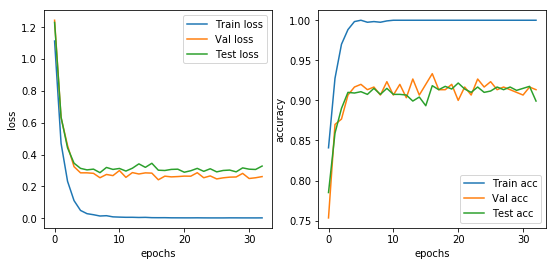

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(9,4))
ax[0].plot(train_loss, label= "Train loss")
ax[0].plot(val_loss, label= "Val loss")
ax[0].plot(test_loss, label= "Test loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(train_acc, label= "Train acc")
ax[1].plot(val_acc, label= "Val acc")
ax[1].plot(test_acc, label= "Test acc")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()

In [ ]:
out=open('model_val%d.txt'%(best_val_acc*10000), 'w')

out.write(str(train_loss) + "\n")
out.write(str(val_loss) + "\n")
out.write(str(test_loss) + "\n")
out.write(str(train_acc) + "\n")
out.write(str(val_acc) + "\n")
out.write(str(test_acc) + "\n")

out.close()

In [ ]:
#!head model_val9466.txt
from google.colab import files
files.download('model_val%d.txt'%(best_val_acc*10000))

In [ ]:
files.download('model_val%d.pt'%(best_val_acc*10000))